In [67]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from config import Config, MulticlassConfig
from preprocessing import (
    build_vocab, save_vocab, load_vocab,
    build_scaler, save_scaler, load_scaler,
    build_label_encoder, save_label_encoder, load_label_encoder,
    MalwareDataset
)
from model import BiLSTM
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [68]:
mode = input("Pilih mode (1=binary, 2=multiclass): ").strip()

if mode == "1":
    cfg = Config()
    model_name = "binary_model.pth"
    data_files = ["fitur_benign.csv", "fitur_malware.csv"]
    file_label_map = {
        "fitur_benign.csv": 0,
        "fitur_malware.csv": 1
    }
    print("Mode: binary")
elif mode == "2":
    cfg = MulticlassConfig()
    model_name = "multiclass_model.pth"
    data_files = [
        "fitur_adware.csv",
        "fitur_coinminer.csv",
        "fitur_Keylogger.csv",
        "fitur_Ransomware.csv",
        "fitur_Rootkit.csv",
        "fitur_trojan.csv"
    ]
    file_label_map = {
        fname: os.path.splitext(fname)[0].split("_")[1].lower()
        for fname in data_files
    }
    print("Mode: multiclass")

max_len = cfg.max_length
batch_size = cfg.batch_size
epochs = cfg.epochs
lr = cfg.learning_rate


Mode: binary


In [69]:
ARTIFACT_DIR = "artifacts"
VOCAB_PATH = os.path.join(ARTIFACT_DIR, "vocab.pkl")
SCALER_PATH = os.path.join(ARTIFACT_DIR, "scaler.pkl")
LABEL_ENCODER_PATH = os.path.join(ARTIFACT_DIR, "label_encoder.pkl")
MODEL_PATH = os.path.join(ARTIFACT_DIR, model_name)

In [ ]:
df_list = []
for fname in data_files:
    df_i = pd.read_csv(os.path.join(fname))
    df_i["label"] = file_label_map[fname]
    df_list.append(df_i)
df = pd.concat(df_list, ignore_index=True)

sequence_cols = [
    'exec_processes_seq', 'exec_paths_seq', 'dns_queries_seq',
    'udp_ports_seq', 'hosts_seq', 'sig_names_seq'
]
seqs = []
for _, row in df.iterrows():
    parts = [
        str(row[col]) for col in sequence_cols
        if pd.notna(row[col]) and row[col] != ""
    ]
    seqs.append(';'.join(parts))

numeric_cols = ['num_execs', 'num_unique_execs', 'num_dns_queries', 'num_udp_packets']
nums = df[numeric_cols].fillna(0).values

labels = df['label'].tolist()

s_tr, s_te, n_tr, n_te, y_tr, y_te = train_test_split(
    seqs, nums, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

s_tr, s_val, n_tr, n_val, y_tr, y_val = train_test_split(
    s_tr, n_tr, y_tr,
    test_size=0.1,
    random_state=42,
    stratify=y_tr
)



In [71]:
vocab = build_vocab(s_tr)
save_vocab(vocab, VOCAB_PATH)
scaler = build_scaler(n_tr)
save_scaler(scaler, SCALER_PATH)
le = build_label_encoder(y_tr)
save_label_encoder(le, LABEL_ENCODER_PATH)

In [ ]:
vocab = load_vocab(VOCAB_PATH)
scaler = load_scaler(SCALER_PATH)
le = load_label_encoder(LABEL_ENCODER_PATH)

train_ds = MalwareDataset(s_tr, n_tr, y_tr, vocab, scaler, le, cfg.max_length)
val_ds   = MalwareDataset(s_val, n_val, y_val, vocab, scaler, le, cfg.max_length)
test_ds  = MalwareDataset(s_te, n_te, y_te, vocab, scaler, le, cfg.max_length)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size)
test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size)

In [ ]:
device = cfg.device
model = BiLSTM(vocab_size=len(vocab), cfg=cfg).to(cfg.device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate)

In [ ]:
best_val_acc = 0.0
for ep in range(epochs):
    model.train()
    train_loss = correct = total = 0
    for batch in train_loader:
        seq, num, lbl = batch["sequence"], batch["numeric"], batch["label"]
        seq, num, lbl = seq.to(device), num.to(device), lbl.to(device)

        optimizer.zero_grad()
        logits = model(seq, num)
        loss = criterion(logits, lbl)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * seq.size(0)
        preds = logits.argmax(dim=1)
        correct   += (preds == lbl).sum().item()
        total     += seq.size(0)

    train_loss /= total
    train_acc   = 100 * correct / total

    # Validation
    model.eval()
    val_loss = correct = total = 0
    with torch.no_grad():
        for batch in val_loader:                # ← pakai val_loader
            seq, num, lbl = batch["sequence"], batch["numeric"], batch["label"]
            seq, num, lbl = seq.to(device), num.to(device), lbl.to(device)

            logits = model(seq, num)
            loss = criterion(logits, lbl)
            val_loss += loss.item() * seq.size(0)

            # untuk binary, threshold, kalau multiclass argmax
            if cfg.num_classes == 2:
                probs = torch.softmax(logits, dim=1)[:,1]
                preds = (probs > cfg.threshold).long()
            else:
                preds = logits.argmax(dim=1)

            correct += (preds == lbl).sum().item()
            total   += seq.size(0)

    val_loss /= total
    val_acc   = 100 * correct / total

    print(f"Epoch {ep+1}/{epochs} | Train: {train_acc:.1f}% ({train_loss:.4f}) | Val: {val_acc:.1f}% ({val_loss:.4f})")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        tag = "Binary" if cfg.num_classes==2 else "Multiclass"
        print(f"{tag} model saved to '{ARTIFACT_DIR}/' folder (best so far)")

Epoch 1/20 | Train: 77.6% (0.5139) | Val: 82.3% (0.4197)
Binary model saved to 'artifacts/' folder (best so far)
Epoch 2/20 | Train: 81.6% (0.4150) | Val: 80.0% (0.4098)
Epoch 3/20 | Train: 81.8% (0.3921) | Val: 80.2% (0.4095)
Epoch 4/20 | Train: 82.8% (0.3846) | Val: 81.2% (0.3969)
Epoch 5/20 | Train: 83.5% (0.3768) | Val: 81.7% (0.4058)
Epoch 6/20 | Train: 84.2% (0.3684) | Val: 80.6% (0.3997)
Epoch 7/20 | Train: 84.4% (0.3664) | Val: 80.2% (0.4144)
Epoch 8/20 | Train: 84.1% (0.3725) | Val: 78.2% (0.4250)
Epoch 9/20 | Train: 84.5% (0.3603) | Val: 80.0% (0.3980)
Epoch 10/20 | Train: 84.5% (0.3573) | Val: 80.4% (0.4062)
Epoch 11/20 | Train: 83.9% (0.3565) | Val: 81.0% (0.4014)
Epoch 12/20 | Train: 84.7% (0.3517) | Val: 80.6% (0.4204)
Epoch 13/20 | Train: 85.2% (0.3509) | Val: 82.1% (0.4160)
Epoch 14/20 | Train: 84.7% (0.3536) | Val: 81.9% (0.4171)
Epoch 15/20 | Train: 85.3% (0.3480) | Val: 81.2% (0.4154)
Epoch 16/20 | Train: 85.4% (0.3468) | Val: 81.9% (0.4207)
Epoch 17/20 | Train: 85.5

In [75]:
print(f"Training done! Best Val accuracy: {best_val_acc:.1f}%")
torch.save(model.state_dict(), MODEL_PATH)
print(f"Training done! Model saved to {MODEL_PATH}")
torch.save(model.state_dict(), MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Training done! Best Val accuracy: 82.3%
Training done! Model saved to artifacts\binary_model.pth
Model saved to artifacts\binary_model.pth


– Dataset size: 496
– Collected preds: 496, labels: 496

Test Accuracy : 81.45%
Test F1-macro : 0.8123


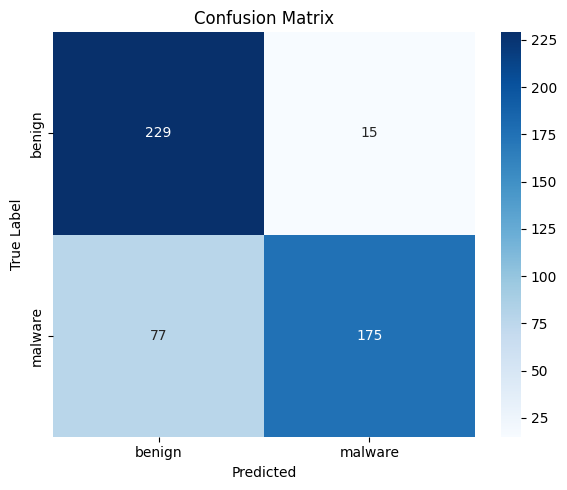


Classification Report:
              precision    recall  f1-score   support

      benign       0.75      0.94      0.83       244
     malware       0.92      0.69      0.79       252

    accuracy                           0.81       496
   macro avg       0.83      0.82      0.81       496
weighted avg       0.84      0.81      0.81       496



In [77]:
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        seq = batch["sequence"].to(device)
        num = batch["numeric"].to(device)
        lbl = batch["label"].to(device)

        logits = model(seq, num) if hasattr(model, "classifier") else model(seq)

        if cfg.num_classes == 2:
            probs = torch.softmax(logits, dim=1)[:, 1]    # P(class=1)
            preds = (probs > cfg.threshold).long()
        else:
            preds = logits.argmax(dim=1)

        all_preds .extend(preds.cpu().numpy())
        all_labels.extend(lbl.cpu().numpy())

print(f"– Dataset size: {len(test_loader.dataset)}")
print(f"– Collected preds: {len(all_preds)}, labels: {len(all_labels)}")

acc      = accuracy_score(all_labels, all_preds) * 100
f1_macro = f1_score(all_labels, all_preds, average="macro")
print(f"\nTest Accuracy : {acc:.2f}%")
print(f"Test F1-macro : {f1_macro:.4f}")

cm = confusion_matrix(all_labels, all_preds)
names = (le.classes_ if cfg.num_classes > 2 else ["benign","malware"])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=names, yticklabels=names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=names))